In [0]:
import requests
import csv
import numpy as np
import pandas as pd
import random

# Load Data

In [0]:
data = pd.read_csv('./data/nlp_finalproj_data_preprocessed.csv', index_col=0)

In [8]:
print(data['cuisine'].value_counts())
print("\nThere are",len(data),"recipes in total.")

Chinese           266
American          250
Mexican           250
Thai              250
Mediterranean     250
Caribbean         250
Italian           250
Vietnamese        250
Middle Eastern    250
French            250
German            250
Japanese          249
Korean            241
Indian            211
African           123
Name: cuisine, dtype: int64

There are 3590 recipes in total.


In [0]:
african = data[data['cuisine']=='African']
chinese = data[data['cuisine']=='Chinese']
french = data[data['cuisine']=='French']
indian = data[data['cuisine']=='Indian']
italian = data[data['cuisine']=='Italian']
mediterranean = data[data['cuisine']=='Mediterranean']
mid_eastern = data[data['cuisine']=='Middle Eastern']
vietnamese = data[data['cuisine']=='Vietnamese']
american = data[data['cuisine']=='American']

# Replace ingredient

In [0]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense,Flatten,Activation
from tensorflow.keras import Sequential 
import gensim 
from gensim.models import Word2Vec, callbacks

from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re

from sklearn import preprocessing


In [0]:
def deduplicate(ingredient):
    # try to uniform the duplicated or similar ingredients
    ingredient = re.sub('canned |fresh |cooked |dried |dry |ground |refrigerated |light |ready-to-use ', '', ingredient)
    ingredient = re.sub('lettuc[^0-9]+', 'lettuc', ingredient)
    ingredient = re.sub('[^0-9]+ salt', 'salt', ingredient)
    ingredient = re.sub('[^0-9]+ basil|basil [^0-9]+', 'basil', ingredient)
    ingredient = re.sub('[^0-9]+ bacon|bacon [^0-9]+', 'bacon', ingredient)
    ingredient = re.sub('[^0-9]+ thyme|thyme [^0-9]+', 'thyme', ingredient)
    ingredient = re.sub('[^0-9]+ cilantro|cilantro [^0-9]+', 'cilantro', ingredient)
    ingredient = re.sub('[^0-9]+ parsley|parsley [^0-9]+', 'parsley', ingredient)
    ingredient = re.sub('[^0-9]+ cinnamon|cinnamon [^0-9]+', 'cinnamon', ingredient)
    ingredient = re.sub('cream[^0-9]+chees|cream chees[^0-9]+', 'cream chees', ingredient)
    ingredient = re.sub('[^0-9]+parmesan[^0-9]+', 'parmesan chees', ingredient)
    ingredient = re.sub('[^0-9]+ peanut butt', 'peanut butt', ingredient)
    ingredient = re.sub('[^0-9]+ chili pepper', 'chili pepp', ingredient)
    ingredient = re.sub('[^0-9]+ nectar', 'nectar', ingredient)
    ingredient = re.sub('[^0-9]+ tofu', 'tofu', ingredient)
    ingredient = re.sub('[^0-9]+ tomato', 'tomato', ingredient)
    ingredient = re.sub('[^0-9]+ bell pepp', 'bell pepp', ingredient)
    ingredient = re.sub('egg roll wra[^0-9]+', 'egg roll wrap', ingredient)
    return ingredient


def clean_data(igd_data):
    # igd_data: a array-like object which contains all ingredients list of training dataset
    # stem: boolean, default to be True
    # *output: a dict
    igds = list()
    raw_igds = igd_data.split(sep=',')
    for i in raw_igds:
        igds.append(re.sub(' *\'|\[|\]|\ *"', '', i)) # delete unneeded punctuations
    return igds

def stem_and_deduplicate(igd_data):
    ps = PorterStemmer()
    stem_igds = [ps.stem(x) for x in igd_data]
    return [deduplicate(y) for y in stem_igds]

In [0]:
# Ingredients of each recipe is a document
# Use all recipes as train dataset
# Skip-gram model

perplexity_logger = PerplexityMetric(corpus=common_corpus, logger='shell')


all_ingredients = [stem_and_deduplicate(clean_data(x)) for x in data['ingredients']]
model_igd = gensim.models.Word2Vec(all_ingredients, min_count = 1, size = 100, window = 5, sg=1, hs=0, iter = 200, negative=10) 

# Some test
for igd in ['onion', 'tomato', 'carrot', 'garlic', 'lemon juic']:
    print(igd+": ["+model_igd.wv.most_similar(positive=[igd], topn=1)[0][0]+"]\n")

In [0]:
def display_pca_scatterplot(model, size=9, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(size,size))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.0002, y+0.0002, word)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


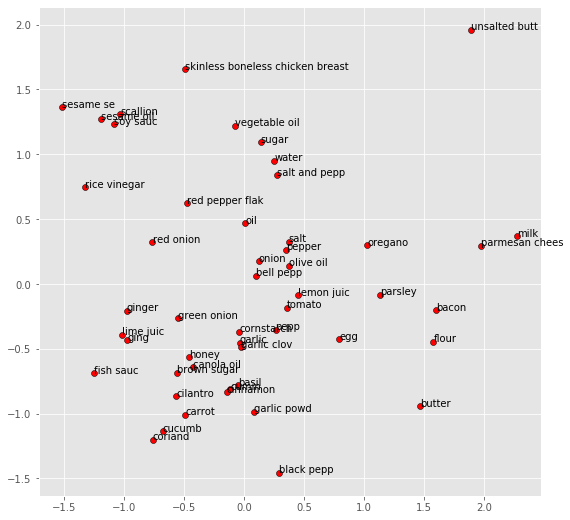

In [38]:
freqWords = model_igd.wv.index2entity[:50]
display_pca_scatterplot(model_igd, size=9, words=freqWords)

###In Different Cuisines

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


onion:   curry powd
tomato:  rice
garlic:  lower sodium soy sauc
sugar:   veget
carrot:  celeri
egg:     broccoli floret


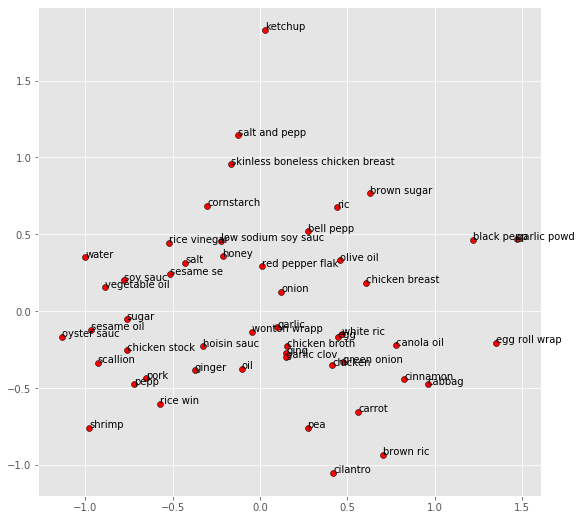

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


onion:   parsley
tomato:  zucchini
garlic:  italian season
sugar:   granulated sugar
carrot:  celeri
egg:     broccoli


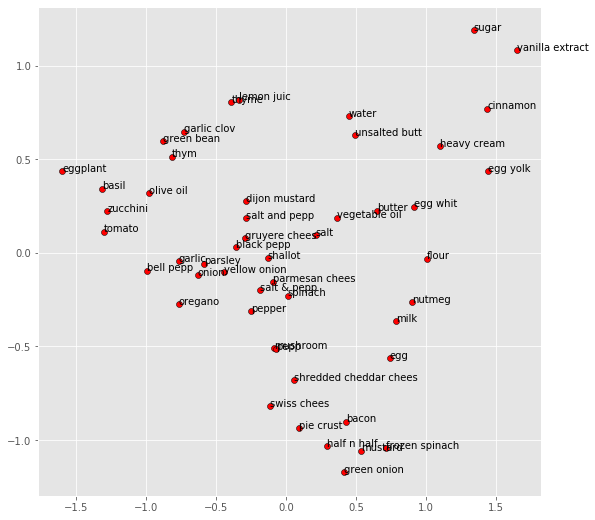

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


onion:   pepper
tomato:  chicken stock
garlic:  chicken stock
sugar:   unsalted butt
carrot:  apple cider vinegar
egg:     dutch processed cocoa


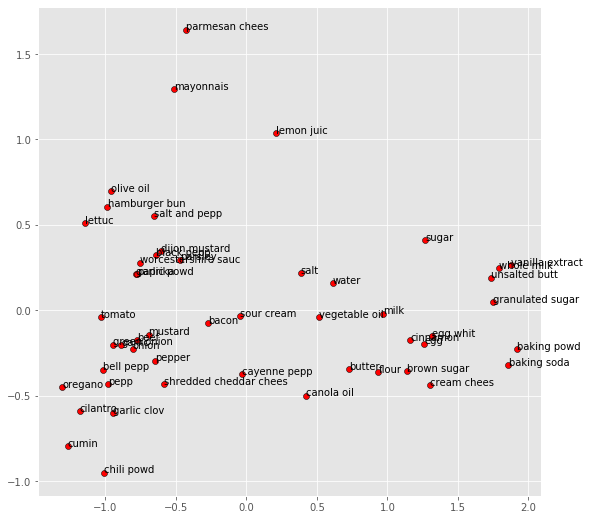

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


onion:   zucchini
tomato:  green bean
garlic:  ditalini pasta
sugar:   water
carrot:  cannellini bean
egg:     flour


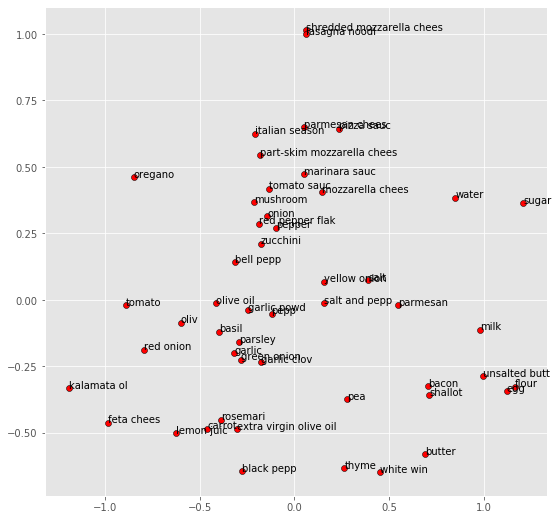

In [39]:
for dataset in [chinese, french, american, mediterranean]:
    cuisine_igd = [stem_and_deduplicate(clean_data(x)) for x in dataset['ingredients']]
    model = gensim.models.Word2Vec(cuisine_igd, min_count = 1, size = 100, window = 5, iter=50, sg=1, hs=0, negative=10) 
    print("onion:  ",model.wv.most_similar(positive=['onion'], topn=1)[0][0])
    print("tomato: ",model.wv.most_similar(positive=['tomato'], topn=1)[0][0])
    print("garlic: ",model.wv.most_similar(positive=['garlic'], topn=1)[0][0])
    print("sugar:  ",model.wv.most_similar(positive=['sugar'], topn=1)[0][0])
    print("carrot: ",model.wv.most_similar(positive=['carrot'], topn=1)[0][0])
    print("egg:    ",model.wv.most_similar(positive=['egg'], topn=1)[0][0])
    freqWords = model.wv.index2entity[:50]
    display_pca_scatterplot(model, words=freqWords)


# Similar Recipes

In [0]:
from gensim.models.doc2vec import TaggedDocument

def model_doc2vec(data):
    sentences= []
    for item_no, line in enumerate(data.values.tolist()):
        sentences.append(TaggedDocument(line,[item_no]))
    return sentences

In [0]:
# MODEL PARAMETERS
DM = 1     # 1 for distributed memory(default); 0 for DBOW
context_window = 5
SEED = 42
WINDOW = 5
EPOCH = 200
NEGATIVE = 10
NS_EXPONENT = -0.25


# BUILD MODELS
pi = model_doc2vec(data['process ingredients'])
ins =  model_doc2vec(data['instructions'])
model_pi = gensim.models.doc2vec.Doc2Vec(documents = pi, dm = DM, window = WINDOW, seed = SEED, epochs = EPOCH, hs=0, negative = NEGATIVE, ns_exponent = NS_EXPONENT)
model_ins = gensim.models.doc2vec.Doc2Vec(documents = ins, dm = DM, window = WINDOW, seed = SEED, epochs = EPOCH, hs=0, negative = NEGATIVE, ns_exponent = NS_EXPONENT)

In [56]:
# Do some test
TARGET = 251  # ID of target recipe


new_vector = model_pi.infer_vector(data['process ingredients'][TARGET])
similar_dishes = model_pi.docvecs.most_similar(positive=[new_vector], topn=5)
print("Similar dishes for:", data['title'][TARGET], "(",data['cuisine'][TARGET],")")
print("\n**** Based on process and ingredients ****")
for (n, similarity) in similar_dishes:
    print("--", data['cuisine'][n], "-",data['title'][n])


new_vector = model_ins.infer_vector(data['process ingredients'][TARGET])
similar_dishes = model_ins.docvecs.most_similar(positive=[new_vector], topn=5)
print("\n**** Based on instructions ****")
for (n, similarity) in similar_dishes:
    print("--", data['cuisine'][n], "-",data['title'][n])


Similar dishes for: Potato Beef Lasagna ( Italian )

**** Based on process and ingredients ****
-- Italian - Potato Beef Lasagna
-- Mediterranean - Potato Beef Lasagna
-- Caribbean - Caribbean Salad with Bananas and Red Onions
-- American - Essential Everyday : Turkey Tetrazzini
-- Japanese - Teriyaki Salmon with Sesame Ginger Rice

**** Based on instructions ****
-- Chinese - Easy Fried Rice with Chicken and Broccolini
-- German - Extreme Lemon and Chocolate Roulade
-- Caribbean - Jerk Chicken
-- Korean - Korean BBQ Beef
-- Vietnamese - Vietnamese Sirloin Skewers With Spicy Carrot Salad


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [73]:
TARGET = 952
CUISINE = 'Korean'

new_vector = model_pi.infer_vector(data['process ingredients'][TARGET])
similar_dishes = model_pi.docvecs.most_similar(positive=[new_vector], topn=40)
similar_limit_cuisine = []
for d in similar_dishes:
    if data['cuisine'][d[0]] == CUISINE:
        similar_limit_cuisine.append(data['title'][d[0]])

print("Similar",CUISINE,"dishes for:", data['title'][TARGET], "(",data['cuisine'][TARGET],")")
print("\n**** Based on process and ingredients ****")
for R in similar_limit_cuisine:
    print(R)

Similar Korean dishes for: Bun Cha: Vietnamese Pork Meatballs ( Vietnamese )

**** Based on process and ingredients ****
Korean Style Refried Beans
Korean Spicy Soft Tofu Stew
Korean Marinated Beef (Bulgogi) – Natural Sauce Version 1
Korean-Style Kimchi Gochujang Chicken Wings


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# Find similar recipe but obey to certain recipe
def show_diets(dataset):
    print("The diets you can choose:")
    for d in dataset['diets'].value_counts().tolist():
        print("#", d)
    print("----------")

def find_recipe(similar_to, obey_diet = None):
    assert type(similar_to) == int
    assert type(obey_diet) in [None, str]
    print("...Searching for similar recipe to", data['title'][similar_to], "...")
    new_vector = model_pi.infer_vector(data['instructions'][similar_to])
    top20 = model_pi.docvecs.most_similar(positive=[new_vector], topn=20)
    if obey_diet != None:
        print("Must obey to following diets:", obey_diet)
        for (n, similarity) in top20:
            if data[str(obey_diet)][n] == 1:
                print("[Recommend recipe]:", data['cuisine'][n], "-",data['title'][n])
    return
                

In [21]:
print(data.columns)


Index(['r_id', 'cuisine', 'title', 'ingredients', 'process', 'instructions',
       'healthScore', 'diets', 'nutritions', 'encoded_ingredients',
       'process ingredients', 'encoded_instructions', 'encoded_diets',
       'no diet', 'dairy fre', 'fodmap friendli', 'gluten fre', 'ketogen',
       'lacto ovo vegetarian', 'paleolith', 'pescatarian', 'primal', 'vegan',
       'whole 30', 'protein', 'fat', 'carbs'],
      dtype='object')


In [82]:
# Test
find_recipe(952, obey_diet = 'whole 30')

...Searching for similar recipe to Bun Cha: Vietnamese Pork Meatballs ...
Must obey to following diets: whole 30
[Recommend recipe]: Vietnamese - Pho Soup with Spicy Veal Meatballs
[Recommend recipe]: French - French String Bean Salad
[Recommend recipe]: Mexican - Paleo Salmon Tacos with Pineapple Salsa
[Recommend recipe]: Thai - Pad thai salad


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
